# Web Mining and Applied NLP (CSIS 44-620)

## P7: Custom Final Project: Web Mining & NLP

### 
Author: Data-Git-Hub <br>
GitHub Project Repository Link: https://github.com/Data-Git-Hub/p7_web_compare <br>
26 July 2025 <br>

### Introduction
In the digital age, a company's "About Us" webpage serves as a cornerstone for conveying brand identity, corporate values, and consumer promise. These pages are often the first point of contact for potential customers, partners, and stakeholders seeking to understand a business beyond its products and services. As such, they present a valuable opportunity for sentiment analysis and comparative linguistic evaluation across competitors within the same industry. The objective of this project is to apply Natural Language Processing (NLP) techniques to extract, analyze, and compare the textual content from the "About Us" webpages of four prominent U.S.-based grocery retailers: Aldi, Albertsons, Hy-Vee, and Piggly Wiggly. <br>

Using tools such as spaCy for tokenization and lemmatization, TextBlob for sentiment analysis, and Matplotlib for data visualization, this project evaluates the thematic density, linguistic structure, and brand messaging of each company’s online narrative. This approach enables a more systematic understanding of how corporate language is used to build identity and trust in a competitive retail environment. Prior research has shown that brand communication via digital content significantly shapes consumer perception, particularly when it comes to clarity, consistency, and emotional appeal (Luo et al., 2021; Kumar & Gupta, 2020). <br>

Beyond raw frequency counts of tokens and lemmas, this analysis introduces sentence scoring mechanisms to highlight which portions of a company's content are most aligned with its frequent themes. By comparing sentence-level relevance scores across firms, we can identify content density, clarity of messaging, and topical focus. Additionally, the use of custom filtering helps eliminate generic industry language and brand-specific terms to ensure a more meaningful comparison of substantive messaging (Camacho-Collados & Pilehvar, 2018). This is particularly important in sectors like grocery retail, where common product references or brand mentions may otherwise skew linguistic analysis. <br>

Ultimately, this project offers both a qualitative and quantitative exploration of how large grocery retailers differentiate themselves,or fail to, through their written digital narratives. The results provide insight into not only what each company says, but how they say it, and how these patterns compare across the industry. Such findings can inform marketing strategies, content optimization, and competitor benchmarking in future business intelligence initiatives (Jansen et al., 2009). <br>

### Imports
Python libraries are collections of pre-written code that provide specific functionalities, making programming more efficient and reducing the need to write code from scratch. These libraries cover a wide range of applications, including data analysis, machine learning, web development, and automation. Some libraries, such as os, sys, math, json, and datetime, come built-in with Python as part of its standard library, providing essential functions for file handling, system operations, mathematical computations, and data serialization. Other popular third-party libraries, like `pandas`, `numpy`, `matplotlib`, `seaborn`, and `scikit-learn`, must be installed separately and are widely used in data science and machine learning. The extensive availability of libraries in Python's ecosystem makes it a versatile and powerful programming language for various domains. <br>

`beautifulsoup4` is a Python library used for parsing HTML and XML documents. It provides Pythonic methods for navigating, searching, and modifying the parse tree, making it ideal for web scraping tasks. BeautifulSoup is particularly useful for extracting data from web pages with inconsistent or poorly structured HTML. It works well with parsers like `html5lib` and `lxml`. <br>
https://www.crummy.com/software/BeautifulSoup/bs4/doc/ <br>

`Counter` is a subclass of Python’s `collections` module used for counting hashable objects. It allows for the quick and easy creation of frequency distributions, such as word or token counts in NLP tasks. <br>
https://docs.python.org/3/library/collections.html#collections.Counter <br>

`html5lib` is a pure-Python HTML parser designed to parse documents the same way modern web browsers do. It is especially useful for handling malformed or messy HTML. When used with `beautifulsoup4`, it provides robust parsing capabilities that help ensure accurate and tolerant extraction of web content. <br>
https://html5lib.readthedocs.io/en/latest/ <br>

`ipykernel` allows Jupyter Notebooks to run Python code by providing the kernel interface used to execute cells and handle communication between the front-end and the Python interpreter. <br>
https://ipykernel.readthedocs.io/en/latest/ <br>

`jupyterlab` is the next-generation user interface for Project Jupyter. It offers a flexible, extensible environment for interactive computing with support for code, markdown, visualizations, and terminals all within a tabbed workspace. JupyterLab enhances productivity by allowing users to organize notebooks, text editors, and data file viewers side by side. <br>
https://jupyterlab.readthedocs.io/en/stable/ <br>

`list` is a built-in Python data structure used to store ordered, mutable sequences of elements. Lists are highly versatile and are used extensively in Python programming for tasks ranging from data storage to iteration and transformation.
https://docs.python.org/3/tutorial/datastructures.html#more-on-lists

`Matplotlib` is a widely used data visualization library that allows users to create static, animated, and interactive plots. It provides extensive tools for generating various chart types, including line plots, scatter plots, histograms, and bar charts, making it a critical library for exploratory data analysis. <br>
https://matplotlib.org/stable/contents.html <br>

`notebook` is the Python package that powers the classic Jupyter Notebook interface. It provides a web-based environment for writing and running code in interactive cells, supporting rich media, visualizations, and markdown documentation. The notebook server manages the execution of kernels and renders notebooks in a browser. This tool is foundational for data analysis, teaching, and exploratory programming workflows. <br>
https://jupyter-notebook.readthedocs.io/en/stable/ <br>

`numpy` is a fundamental package for scientific computing in Python. It provides efficient support for numerical operations on large, multi-dimensional arrays and matrices, along with a wide range of mathematical functions such as mean, median, and standard deviation. It is widely used in data analysis, machine learning, and engineering.
https://numpy.org/

`Pandas` is a powerful data manipulation and analysis library that provides flexible data structures, such as DataFrames and Series. It is widely used for handling structured datasets, enabling easy data cleaning, transformation, and aggregation. Pandas is essential for data preprocessing in machine learning and statistical analysis. <br>
https://pandas.pydata.org/docs/ <br>

The `requests` library simplifies making HTTP requests in Python, allowing you to send GET, POST, and other types of requests to interact with APIs or web services. <br>
 https://docs.python-requests.org/en/latest/ <br>

`spaCy` is an advanced NLP library for Python that provides tools for tokenization, part-of-speech tagging, named entity recognition, and more, using pre-trained pipelines. <br>
https://spacy.io/ <br>

`spacytextblob` is a plugin for spaCy that adds sentiment analysis capabilities by integrating TextBlob's polarity and subjectivity scores into spaCy’s pipeline. <br>
https://github.com/AndrewIbrahim/spacy-textblob <br>

`TextBlob` is a Python library for processing textual data, built on top of `nltk` and `pattern`. It provides a simple API for common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, translation, and sentiment analysis. Its intuitive design and built-in sentiment scoring functions make it especially useful for quick prototyping and educational applications. <br>
https://textblob.readthedocs.io/en/dev/ <br>

In [82]:
# Imports and initial setup for NLP Article Comparison Notebook

import os
import pandas as pd
import requests
import pickle
import ast
import re
from bs4 import BeautifulSoup
from collections import Counter, defaultdict
from typing import List

import spacy
from spacy.lang.en import EnglishDefaults
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display, HTML
from textblob import TextBlob

# Load or download spaCy language model
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    import subprocess
    subprocess.run(["python", "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm")

#### Section 1. Extract and Save About Us for Each Company's Website
We are writing code that extracts the full HTML content from the webpages at https://www.traderjoes.com/home/about-us, https://www.aldi.us/en/about-aldi/, https://www.albertsons.com/about-us.html, https://www.hy-vee.com/corporate/our-company/our-history/, and https://www.pigglywiggly.com/history/, then serializes the output to `.pkl` (or another appropriate format) for persistent storage. These files are saved in a directory called `dump_folder/` so they can be reliably loaded later for NLP processing and analysis. As part of the code, if we can not access the webpage, we will receive an error message, informing us of a failure to capture from the internet. <br> 

In [74]:
# Section 1: Extract and Save Article HTML with Header Fix, Timeout, and Logging

# Create a folder to store the dumped HTML if it doesn't exist
os.makedirs("dump_folder", exist_ok=True)

# User-Agent header to mimic a real browser
headers = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/115.0.0.0 Safari/537.36"
    )
}

# URLs to extract (you can comment out REI if it keeps stalling)
urls = {
    "tradejoes": "https://www.traderjoes.com/home/about-us",
    "aldi": "https://www.aldi.us/en/about-aldi/",
    "albertsons": "https://www.albertsons.com/about-us.html",
    "hyvee": "https://www.hy-vee.com/corporate/our-company/our-history/",
    "pigglywiggly": "https://www.pigglywiggly.com/history/"
}

# Loop through and extract HTML content
for name, url in urls.items():
    try:
        print(f"\n Fetching {name.title()} - {url}")
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        html_content = soup.prettify()

        # Save to pickle file
        with open(f"dump_folder/{name}.pkl", "wb") as f:
            pickle.dump(html_content, f)

        print(f"HTML from {url} saved to dump_folder/{name}.pkl")

    except requests.exceptions.Timeout:
        print(f"Timeout: Skipping {name.title()} due to slow response.")
    except Exception as e:
        print(f"Failed to fetch {name.title()} ({url}): {e}")


 Fetching Tradejoes - https://www.traderjoes.com/home/about-us
Failed to fetch Tradejoes (https://www.traderjoes.com/home/about-us): 403 Client Error: Forbidden for url: https://www.traderjoes.com/home/about-us

 Fetching Aldi - https://www.aldi.us/en/about-aldi/
HTML from https://www.aldi.us/en/about-aldi/ saved to dump_folder/aldi.pkl

 Fetching Albertsons - https://www.albertsons.com/about-us.html
HTML from https://www.albertsons.com/about-us.html saved to dump_folder/albertsons.pkl

 Fetching Hyvee - https://www.hy-vee.com/corporate/our-company/our-history/
HTML from https://www.hy-vee.com/corporate/our-company/our-history/ saved to dump_folder/hyvee.pkl

 Fetching Pigglywiggly - https://www.pigglywiggly.com/history/
HTML from https://www.pigglywiggly.com/history/ saved to dump_folder/pigglywiggly.pkl


#### Section 2. Load and Display About Us Text Conversion of Each Company's Website
We are writing code that reads the serialized HTML files from the `dump_folder/` created in Section 1. Using BeautifulSoup, we extract the plain text content from each company's "About Us" page with `.get_text()` and display a preview of the text. The full parsed text is then saved as a `.txt` file into a folder named `parse/` for later NLP analysis. <br>

#### NOTE - Preload Filter Dictionary

In [84]:
# Section 2: Load and Display Article Text

# Ensure output folder exists
os.makedirs("parse", exist_ok=True)

# List of company identifiers matching Section 1
companies = ["tradejoes", "aldi", "albertsons", "hyvee", "pigglywiggly"]

for company in companies:
    try:
        # Load raw HTML from the dumped pickle file
        with open(f"dump_folder/{company}.pkl", "rb") as f:
            html_content = pickle.load(f)

        # Parse HTML with BeautifulSoup
        soup = BeautifulSoup(html_content, 'html.parser')
        plain_text = soup.get_text(separator=' ', strip=True)

        # Display a preview of the parsed text
        print(f"\n Parsed Text Preview for {company.capitalize()}:\n")
        print(plain_text[:1000] + "...\n")  # Print first 1000 characters

        # Save to a .txt file in the "parse" directory
        with open(f"parse/{company}.txt", "w", encoding="utf-8") as out_file:
            out_file.write(plain_text)

        print(f"✔ Plain text saved to parse/{company}.txt")

    except FileNotFoundError:
        print(f"File not found for {company}. Did the HTML fail to download in Section 1?")
    except Exception as e:
        print(f"Error processing {company}: {e}")
        
# Pre-Load custom exclusion list from file for both tokens and lemmas
exclude_path = "filters/bad_words.txt"  

if os.path.exists(exclude_path):
    with open(exclude_path, "r", encoding="utf-8") as f:
        custom_exclude = set(line.strip().lower() for line in f if line.strip())
    print(f" Loaded {len(custom_exclude)} custom exclusion terms from {exclude_path}")
else:
    print(f" Exclusion file not found at {exclude_path}. Continuing with empty list.")
    custom_exclude = set() 
    
# Create a blank English nlp pipeline
nlp = English()

# Add sentence segmenter
nlp.add_pipe("sentencizer")

# Add simple rule-based lemmatizer via lookups
try:
    from spacy.lang.en import EnglishDefaults
    from spacy.lookups import Lookups

    # Load default lookups
    lookups = Lookups()
    lookups.add_table("lemma_rules", EnglishDefaults.lex_attr_getters["lemma_rules"])
    lookups.add_table("lemma_index", EnglishDefaults.lex_attr_getters["lemma_index"])
    lookups.add_table("lemma_exc", EnglishDefaults.lex_attr_getters["lemma_exc"])

    # Register the lemmatizer
    nlp.initialize(lambda: {"lookups": lookups})
    nlp.add_pipe("lemmatizer", config={"mode": "rule"})

except Exception as e:
    print(f"Could not load lemmatizer: {e}")
    doc = nlp(text)
lemmas = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

File not found for tradejoes. Did the HTML fail to download in Section 1?

 Parsed Text Preview for Aldi:

About ALDI  | ALDI US Help Skip to Content Products Weekly Specials Featured Recipes Search Search Search Results Log in Cart Your Cart (0 products) Your cart is empty. But full of possibilities Let's go shopping Buy Again Restock your favorites! Subtotal ‎ Continue to Checkout Products Fresh Produce Fresh Fruit Fresh Vegetables Salad Kits Flowers and Plants Healthy Living Healthy Food & Snacks Fresh Meat & Seafood Fresh Beef Fresh Poultry Fresh Pork Fresh Sausage Fresh Seafood Other Meat & Plant-Based Proteins Snacks Chips, Crackers & Popcorn Cookies & Sweets Nuts & Dried Fruit Trail Mix Jerky & Dried Meat BBQ & Picnic Grilled Meat & Seafood Cookout Essentials BBQ & Picnic Supplies Frozen Foods Frozen Meat, Poultry & Seafood Frozen Vegetables Frozen Ice Cream & Desserts Frozen Fruit Frozen Breakfast Frozen Meals & Sides Frozen Appetizers & Snacks Frozen Pizza Frozen Sandwiches Da

#### Section 3. Analyze Most Frequent Tokens with spaCy
We are loading each company's parsed plain text from the `parse/` directory and analyzing it using a trained `spaCy` pipeline. We filter out tokens that are punctuation, stop words, or whitespace, and convert each token to lowercase. For each company, we extract and print the ten most frequent tokens along with their frequencies. We also save these top tokens in a new folder called `tps_report/` for later use in deliverables. <br>

In [56]:
# Section 3: Analyze Most Frequent Tokens with spaCy (Tabular Output)

os.makedirs("tps_report", exist_ok=True)

companies = ["tradejoes", "aldi", "albertsons", "hyvee", "pigglywiggly"]

# Dictionary to store top tokens for table display
token_table = {}

for company in companies:
    try:
        # Load parsed text
        with open(f"parse/{company}.txt", "r", encoding="utf-8") as f:
            text = f.read()

        # Process with spaCy
        doc = nlp(text)

        # Filter and lowercase tokens
        filtered_tokens = [
            token.text.lower()
            for token in doc
            if not token.is_stop and not token.is_punct and not token.is_space
        ]

        # Count frequency and get top 10
        token_freq = Counter(filtered_tokens)
        top_tokens = token_freq.most_common(10)

        # Save to file
        with open(f"tps_report/{company}_tokens.txt", "w", encoding="utf-8") as out_file:
            for token, freq in top_tokens:
                out_file.write(f"{token}: {freq}\n")

        # Store formatted tokens for DataFrame
        token_table[company] = [f"{token} ({freq})" for token, freq in top_tokens]

    except FileNotFoundError:
        print(f" Could not find parse/{company}.txt")
        token_table[company] = ["N/A"] * 10
    except Exception as e:
        print(f" Error processing {company}: {e}")
        token_table[company] = ["Error"] * 10

# Convert to DataFrame for tabular display
token_df = pd.DataFrame(token_table, index=[f"Rank {i+1}" for i in range(10)])

# Display the token table
display(HTML("<h3> Top 10 Tokens per Company</h3>"))
display(token_df)

# Print saved confirmation
for company in companies:
    print(f"✔ Saved top tokens to tps_report/{company}_tokens.txt")
    
# Save token frequency table to CSV
token_df.to_csv("tps_report/token_frequency_table.csv", index=True)
    

 Could not find parse/tradejoes.txt


,tradejoes,aldi,albertsons,hyvee,pigglywiggly
Rank 1,N/A,aldi (28),albertsons (19),hy (107),piggly (20)
Rank 2,N/A,new (15),care (17),vee (105),wiggly (20)
Rank 3,N/A,products (13),try (15),store (62),® (18)
Rank 4,N/A,opens (13),deli (14),stores (38),saunders (8)
Rank 5,N/A,tab (13),load (14),company (37),store (7)
Rank 6,N/A,fresh (11),frozen (10),iowa (35),grocery (7)
Rank 7,N/A,frozen (11),® (9),new (23),c&s (6)
Rank 8,N/A,cart (10),foods (8),opened (23),llc (5)
Rank 9,N/A,supplies (9),sorry (8),year (18),history (4)
Rank 10,N/A,food (8),canned (8),vredenburg (17),wholesale (4)


✔ Saved top tokens to tps_report/tradejoes_tokens.txt
✔ Saved top tokens to tps_report/aldi_tokens.txt
✔ Saved top tokens to tps_report/albertsons_tokens.txt
✔ Saved top tokens to tps_report/hyvee_tokens.txt
✔ Saved top tokens to tps_report/pigglywiggly_tokens.txt


#### Section 3.1. Analyze Most Frequent Tokens with spaCy with Filter
In this section, we extend our original token frequency analysis by applying an additional layer of filtering using a custom exclusion list. This list is stored in a text file located in the `filters/` directory and contains manually specified words that are either too generic or irrelevant for our domain-specific analysis (e.g., "company", "store", "product"). <br>

The process mirrors Section 3, where we use a trained `spaCy` pipeline to tokenize the plain text content from each company's parsed "About Us" page. We apply filters to remove punctuation, stop words, whitespace, and now, any word present in our exclusion list. The result is a more targeted and refined set of tokens that better represent meaningful themes and terminology used by each company. <br>

We extract the ten most frequent filtered tokens per company and display them in a comparative table. Additionally, the top tokens for each company are saved to individual files in the `tps_report/` directory using the `_tokens_filtered.txt` suffix, and the full table is saved as `token_frequency_table_filtered.csv` for future reference or analysis. <br>

In [57]:
# Section 3.1: Analyze Most Frequent Tokens with spaCy + Custom Exclusion Filter

os.makedirs("tps_report", exist_ok=True)

# Load exclusion list (if not loaded earlier)
exclude_path = "filters/bad_words.txt"
if os.path.exists(exclude_path):
    with open(exclude_path, "r", encoding="utf-8") as f:
        custom_exclude = set(line.strip().lower() for line in f if line.strip())
else:
    print(f" Exclusion file not found at {exclude_path}. Using empty list.")
    custom_exclude = set()

# Reuse companies list
token_table_filtered = {}
top_n = 10

for company in companies:
    try:
        with open(f"parse/{company}.txt", "r", encoding="utf-8") as f:
            text = f.read()

        doc = nlp(text)

        # Apply filtering with custom exclusion
        filtered_tokens = [
            token.text.lower()
            for token in doc
            if not token.is_stop
            and not token.is_punct
            and not token.is_space
            and token.text.lower() not in custom_exclude
        ]

        token_freq = Counter(filtered_tokens)
        top_tokens = token_freq.most_common(top_n)

        # Save to new filtered file
        with open(f"tps_report/{company}_tokens_filtered.txt", "w", encoding="utf-8") as out_file:
            for token, freq in top_tokens:
                out_file.write(f"{token}: {freq}\n")

        token_table_filtered[company] = [f"{token} ({freq})" for token, freq in top_tokens]

    except FileNotFoundError:
        print(f" parse/{company}.txt not found.")
        token_table_filtered[company] = ["N/A"] * top_n
    except Exception as e:
        print(f" Error processing {company}: {e}")
        token_table_filtered[company] = ["Error"] * top_n

# Create and display table
import pandas as pd
token_df_filtered = pd.DataFrame(token_table_filtered, index=[f"Rank {i+1}" for i in range(top_n)])
display(HTML("<h3> Top 10 Filtered Tokens per Company</h3>"))
display(token_df_filtered)

# Save table
token_df_filtered.to_csv("tps_report/token_frequency_table_filtered.csv", index=True)
print(" Filtered token frequency table saved to tps_report/token_frequency_table_filtered.csv")

# Confirmation
for company in companies:
    print(f" Saved filtered top tokens to tps_report/{company}_tokens_filtered.txt")


 parse/tradejoes.txt not found.


,tradejoes,aldi,albertsons,hyvee,pigglywiggly
Rank 1,N/A,new (15),care (17),iowa (35),saunders (8)
Rank 2,N/A,products (13),try (15),new (23),c&s (6)
Rank 3,N/A,opens (13),deli (14),opened (23),history (4)
Rank 4,N/A,tab (13),load (14),year (18),wholesale (4)
Rank 5,N/A,fresh (11),frozen (10),vredenburg (17),grocers (4)
Rank 6,N/A,frozen (11),sorry (8),customers (17),brands (3)
Rank 7,N/A,cart (10),canned (8),introduced (16),contact (3)
Rank 8,N/A,supplies (9),sign (7),employees (13),korner (3)
Rank 9,N/A,snacks (8),unable (7),hyde (11),coloring (3)
Rank 10,N/A,meat (8),menu (7),des (11),book (3)


 Filtered token frequency table saved to tps_report/token_frequency_table_filtered.csv
 Saved filtered top tokens to tps_report/tradejoes_tokens_filtered.txt
 Saved filtered top tokens to tps_report/aldi_tokens_filtered.txt
 Saved filtered top tokens to tps_report/albertsons_tokens_filtered.txt
 Saved filtered top tokens to tps_report/hyvee_tokens_filtered.txt
 Saved filtered top tokens to tps_report/pigglywiggly_tokens_filtered.txt


#### Section 4. Analyze Most Frequent Lemmas with spaCy
We are analyzing the same parsed text from each company's "About Us" page using `spaCy`, but this time we're focusing on lemmas, the base or dictionary forms of words. After filtering out stop words, punctuation, and whitespace, we identify the Top 10 most frequent lemmas for each company. We print these results in a table and save both individual and tabular outputs to the `tps_report/` folder for later analysis. <br>

In [58]:
# Section 4: Analyze Most Frequent Lemmas with spaCy

lemma_table = {}
top_n = 10  # Top 10 lemmas

for company in companies:
    try:
        # Load parsed text
        with open(f"parse/{company}.txt", "r", encoding="utf-8") as f:
            text = f.read()

        # Process with spaCy
        doc = nlp(text)

        # Filter and extract lemmas
        filtered_lemmas = [
            token.lemma_.lower()
            for token in doc
            if not token.is_stop and not token.is_punct and not token.is_space
        ]

        # Count and get top N lemmas
        lemma_freq = Counter(filtered_lemmas)
        top_lemmas = lemma_freq.most_common(top_n)

        # Save to file
        with open(f"tps_report/{company}_lemmas.txt", "w", encoding="utf-8") as out_file:
            for lemma, freq in top_lemmas:
                out_file.write(f"{lemma}: {freq}\n")

        # Store for table
        lemma_table[company] = [f"{lemma} ({freq})" for lemma, freq in top_lemmas]

    except FileNotFoundError:
        print(f" Could not find parse/{company}.txt")
        lemma_table[company] = ["N/A"] * top_n
    except Exception as e:
        print(f" Error processing {company}: {e}")
        lemma_table[company] = ["Error"] * top_n

# Create and display lemma frequency table
lemma_df = pd.DataFrame(lemma_table, index=[f"Rank {i+1}" for i in range(top_n)])

display(HTML("<h3> Top 10 Lemmas per Company</h3>"))
display(lemma_df)

# Save to CSV
lemma_df.to_csv("tps_report/lemma_frequency_table.csv", index=True)
print(" Lemma frequency table saved to tps_report/lemma_frequency_table.csv")

# Confirmation messages
for company in companies:
    print(f"✔ Saved top lemmas to tps_report/{company}_lemmas.txt")

 Could not find parse/tradejoes.txt


,tradejoes,aldi,albertsons,hyvee,pigglywiggly
Rank 1,N/A,aldi (28),albertsons (18),hy (107),piggly (20)
Rank 2,N/A,price (15),care (17),vee (105),wiggly (20)
Rank 3,N/A,new (15),try (15),store (95),® (18)
Rank 4,N/A,product (14),deli (14),company (37),store (11)
Rank 5,N/A,open (13),load (14),iowa (35),grocery (7)
Rank 6,N/A,tab (13),shop (12),year (24),c&s (6)
Rank 7,N/A,fresh (11),frozen (10),new (23),llc (5)
Rank 8,N/A,frozen (11),® (9),open (23),saunder (5)
Rank 9,N/A,cart (10),store (9),customer (18),history (4)
Rank 10,N/A,shop (9),foods (8),employee (17),wholesale (4)


 Lemma frequency table saved to tps_report/lemma_frequency_table.csv
✔ Saved top lemmas to tps_report/tradejoes_lemmas.txt
✔ Saved top lemmas to tps_report/aldi_lemmas.txt
✔ Saved top lemmas to tps_report/albertsons_lemmas.txt
✔ Saved top lemmas to tps_report/hyvee_lemmas.txt
✔ Saved top lemmas to tps_report/pigglywiggly_lemmas.txt


#### Section 4.1. Analyze Most Frequent Lemmas with spaCy with Filter
In this section, we extend our lemma frequency analysis by applying the custom exclusion list loaded earlier from the `filters/` directory. This list contains terms we want to omit from our results due to their generic or domain-irrelevant nature. <br>

Using a trained `spaCy` pipeline, we extract and lemmatize tokens from each company's parsed text. We remove stop words, punctuation, whitespace, and any lemma present in the custom exclusion list. We then identify the ten most frequent filtered lemmas for each company and present them in a table for easy comparison. <br>

Each company's top lemmas are also saved individually in the `tps_report/` directory using a `_lemmas_filtered.txt` suffix, and the complete table is saved as `lemma_frequency_table_filtered.csv` for future analysis. <br.>

In [59]:
# Section 4.1: Analyze Most Frequent Lemmas with spaCy and Custom Exclusion Filter

os.makedirs("tps_report", exist_ok=True)

# Assume custom_exclude is already loaded from earlier cell
lemma_table_filtered = {}
top_n = 10

for company in companies:
    try:
        with open(f"parse/{company}.txt", "r", encoding="utf-8") as f:
            text = f.read()

        doc = nlp(text)

        # Filter lemmas with custom exclusions
        filtered_lemmas = [
            token.lemma_.lower()
            for token in doc
            if not token.is_stop
            and not token.is_punct
            and not token.is_space
            and token.lemma_.lower() not in custom_exclude
        ]

        lemma_freq = Counter(filtered_lemmas)
        top_lemmas = lemma_freq.most_common(top_n)

        # Save individual lemma results
        with open(f"tps_report/{company}_lemmas_filtered.txt", "w", encoding="utf-8") as out_file:
            for lemma, freq in top_lemmas:
                out_file.write(f"{lemma}: {freq}\n")

        # Save to table
        lemma_table_filtered[company] = [f"{lemma} ({freq})" for lemma, freq in top_lemmas]

    except FileNotFoundError:
        print(f" parse/{company}.txt not found.")
        lemma_table_filtered[company] = ["N/A"] * top_n
    except Exception as e:
        print(f" Error processing {company}: {e}")
        lemma_table_filtered[company] = ["Error"] * top_n

# Create and display table
lemma_df_filtered = pd.DataFrame(lemma_table_filtered, index=[f"Rank {i+1}" for i in range(top_n)])
display(HTML("<h3> Top 10 Filtered Lemmas per Company</h3>"))
display(lemma_df_filtered)

# Save to CSV
lemma_df_filtered.to_csv("tps_report/lemma_frequency_table_filtered.csv", index=True)
print(" Filtered lemma frequency table saved to tps_report/lemma_frequency_table_filtered.csv")

# Confirmation
for company in companies:
    print(f" Saved filtered top lemmas to tps_report/{company}_lemmas_filtered.txt")

 parse/tradejoes.txt not found.


,tradejoes,aldi,albertsons,hyvee,pigglywiggly
Rank 1,N/A,price (15),care (17),iowa (35),c&s (6)
Rank 2,N/A,new (15),try (15),year (24),saunder (5)
Rank 3,N/A,product (14),deli (14),new (23),history (4)
Rank 4,N/A,open (13),load (14),open (23),wholesale (4)
Rank 5,N/A,tab (13),shop (12),customer (18),grocers (4)
Rank 6,N/A,fresh (11),frozen (10),employee (17),service (4)
Rank 7,N/A,frozen (11),sorry (8),vredenburg (17),brands (3)
Rank 8,N/A,cart (10),canned (8),introduce (16),contact (3)
Rank 9,N/A,shop (9),sign (7),service (11),korner (3)
Rank 10,N/A,supplies (9),unable (7),hyde (11),coloring (3)


 Filtered lemma frequency table saved to tps_report/lemma_frequency_table_filtered.csv
 Saved filtered top lemmas to tps_report/tradejoes_lemmas_filtered.txt
 Saved filtered top lemmas to tps_report/aldi_lemmas_filtered.txt
 Saved filtered top lemmas to tps_report/albertsons_lemmas_filtered.txt
 Saved filtered top lemmas to tps_report/hyvee_lemmas_filtered.txt
 Saved filtered top lemmas to tps_report/pigglywiggly_lemmas_filtered.txt


#### Section 4.2. Comparison Between Tokens and Lemmas with Filter
In this section, we are comparing the most frequent tokens and lemmas extracted from each company's “About Us” web page after applying a custom exclusion filter. This filter removes non-informative or brand-specific terms (such as "store," "food," or company names) that would otherwise dominate the frequency analysis due to the nature of grocery industry marketing content.

By processing both tokens and lemmas through the same filtering criteria, we aim to better understand how lemmatization (reducing words to their base form) changes the representation of key concepts across the companies. Lemmatization groups together word variants (e.g., "opens" and "open"), which may highlight more general themes than raw token counts.

We load the filtered top 10 tokens and lemmas (saved from previous sections) for each company from the `tps_report/` directory and organize them into a side-by-side comparison table. This allows us to directly observe differences in word representation and frequency between the two approaches. The final comparison is saved to a CSV file for inclusion in the final deliverable.

In [60]:
# Ensure the report folder exists
os.makedirs("tps_report", exist_ok=True)

# Companies to compare
companies = ["tradejoes", "aldi", "albertsons", "hyvee", "pigglywiggly"]

# Initialize comparison data
comparison_data = {}

for company in companies:
    token_path = f"tps_report/{company}_tokens_filtered.txt"
    lemma_path = f"tps_report/{company}_lemmas_filtered.txt"
    
    try:
        # Read token file (formatted as "word: freq")
        with open(token_path, "r", encoding="utf-8") as f:
            token_lines = f.readlines()
        tokens = [line.strip() for line in token_lines if ":" in line]
        
        # Read lemma file (formatted as "word: freq")
        with open(lemma_path, "r", encoding="utf-8") as f:
            lemma_lines = f.readlines()
        lemmas = [line.strip() for line in lemma_lines if ":" in line]

        # Normalize both lists to the same length
        max_len = max(len(tokens), len(lemmas))
        tokens += [""] * (max_len - len(tokens))
        lemmas += [""] * (max_len - len(lemmas))

        # Store in comparison data
        comparison_data[company] = {
            "Top Tokens": tokens,
            "Top Lemmas": lemmas
        }

    except Exception as e:
        print(f" Could not load data for {company}: {e}")
        comparison_data[company] = {
            "Top Tokens": ["N/A: 0"] * 10,
            "Top Lemmas": ["N/A: 0"] * 10
        }

# Build DataFrame for side-by-side comparison
comparison_rows = []
for i in range(10):  # Assuming top 10
    row = {}
    for company in companies:
        row[f"{company}_token"] = comparison_data[company]["Top Tokens"][i]
        row[f"{company}_lemma"] = comparison_data[company]["Top Lemmas"][i]
    comparison_rows.append(row)

comparison_df = pd.DataFrame(comparison_rows, index=[f"Rank {i+1}" for i in range(10)])

# Display and Save
from IPython.display import display, HTML
display(HTML("<h3>Comparison Between Top Tokens and Lemmas (Filtered)</h3>"))
display(comparison_df)

# Save to CSV
comparison_df.to_csv("tps_report/token_vs_lemma_comparison_filtered.csv")
print(" Comparison table saved to tps_report/token_vs_lemma_comparison_filtered.csv")

 Could not load data for tradejoes: [Errno 2] No such file or directory: 'tps_report/tradejoes_tokens_filtered.txt'


,tradejoes_token,tradejoes_lemma,aldi_token,aldi_lemma,albertsons_token,albertsons_lemma,hyvee_token,hyvee_lemma,pigglywiggly_token,pigglywiggly_lemma
Rank 1,N/A: 0,N/A: 0,new: 15,price: 15,care: 17,care: 17,iowa: 35,iowa: 35,saunders: 8,c&s: 6
Rank 2,N/A: 0,N/A: 0,products: 13,new: 15,try: 15,try: 15,new: 23,year: 24,c&s: 6,saunder: 5
Rank 3,N/A: 0,N/A: 0,opens: 13,product: 14,deli: 14,deli: 14,opened: 23,new: 23,history: 4,history: 4
Rank 4,N/A: 0,N/A: 0,tab: 13,open: 13,load: 14,load: 14,year: 18,open: 23,wholesale: 4,wholesale: 4
Rank 5,N/A: 0,N/A: 0,fresh: 11,tab: 13,frozen: 10,shop: 12,vredenburg: 17,customer: 18,grocers: 4,grocers: 4
Rank 6,N/A: 0,N/A: 0,frozen: 11,fresh: 11,sorry: 8,frozen: 10,customers: 17,employee: 17,brands: 3,service: 4
Rank 7,N/A: 0,N/A: 0,cart: 10,frozen: 11,canned: 8,sorry: 8,introduced: 16,vredenburg: 17,contact: 3,brands: 3
Rank 8,N/A: 0,N/A: 0,supplies: 9,cart: 10,sign: 7,canned: 8,employees: 13,introduce: 16,korner: 3,contact: 3
Rank 9,N/A: 0,N/A: 0,snacks: 8,shop: 9,unable: 7,sign: 7,hyde: 11,service: 11,coloring: 3,korner: 3
Rank 10,N/A: 0,N/A: 0,meat: 8,supplies: 9,menu: 7,unable: 7,des: 11,hyde: 11,book: 3,coloring: 3


 Comparison table saved to tps_report/token_vs_lemma_comparison_filtered.csv


#### Section 4.3. Polarity Scores for Each Company's Website
In this section, we analyze the overall sentiment polarity of each company’s "About Us" webpage using the `TextBlob` library. Polarity scores range from -1.0 (very negative) to +1.0 (very positive). We compute one polarity score per company by loading the parsed text from the `parse/` folder.

To help visualize how these companies compare in sentiment, we generate a quadrant scatter plot showing each company’s polarity on the vertical axis and text length (as a proxy for verbosity or detail) on the horizontal axis. This provides insight into how positive or negative their messaging is and how much content they include.

We omit Trader Joe’s due to missing data and save the resulting visualization as a `.jpg` file to the `tps_report/` folder.

Aldi — Polarity: 0.204, Length: 1234 words
Albertsons — Polarity: 0.0866, Length: 1542 words
Hyvee — Polarity: 0.1426, Length: 3558 words
Pigglywiggly — Polarity: 0.1043, Length: 600 words


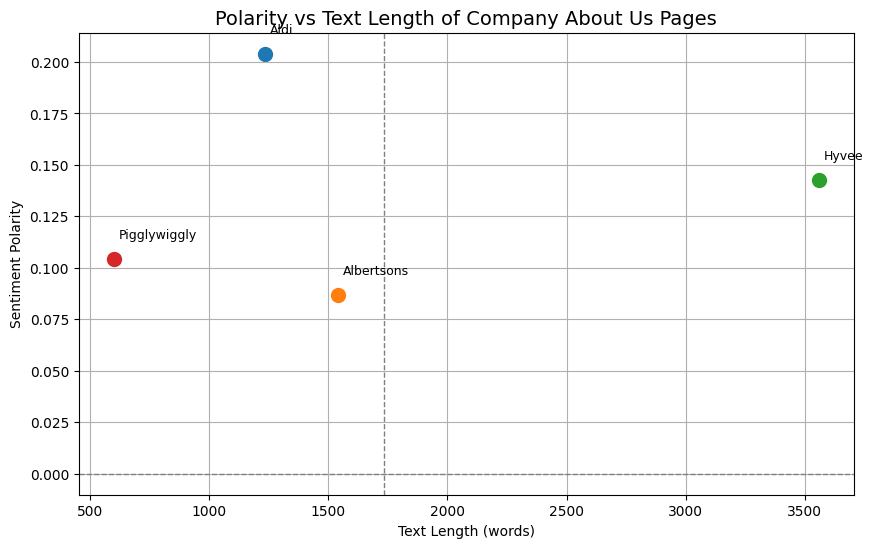


✔ Polarity quadrant plot saved to: tps_report/polarity_quadrant_plot.jpg


In [61]:
os.makedirs("tps_report", exist_ok=True)

# Companies to evaluate (drop 'tradejoes')
companies = ["aldi", "albertsons", "hyvee", "pigglywiggly"]

polarity_scores = {}
text_lengths = {}

# Compute polarity and text length
for company in companies:
    try:
        with open(f"parse/{company}.txt", "r", encoding="utf-8") as f:
            text = f.read()
            blob = TextBlob(text)
            polarity_scores[company] = round(blob.sentiment.polarity, 4)
            text_lengths[company] = len(text.split())

            print(f"{company.capitalize()} — Polarity: {polarity_scores[company]}, Length: {text_lengths[company]} words")
    except FileNotFoundError:
        print(f" Could not load parse/{company}.txt")
        polarity_scores[company] = None
        text_lengths[company] = 0

# Prepare scatter plot
x = [text_lengths[c] for c in companies]
y = [polarity_scores[c] for c in companies]

plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(sum(x)/len(x), color='gray', linestyle='--', linewidth=1)

for i, company in enumerate(companies):
    plt.scatter(x[i], y[i], s=100)
    plt.text(x[i]+20, y[i]+0.01, company.capitalize(), fontsize=9)

plt.title("Polarity vs Text Length of Company About Us Pages", fontsize=14)
plt.xlabel("Text Length (words)")
plt.ylabel("Sentiment Polarity")
plt.grid(True)

# Save and show
plot_path = "tps_report/polarity_quadrant_plot.jpg"
plt.savefig(plot_path, format="jpg", dpi=300)
plt.show()

print(f"\n✔ Polarity quadrant plot saved to: {plot_path}")

The polarity and length metrics of each company's "About Us" webpage offer insight into the tone and depth of their brand narratives. Among the four companies analyzed, Aldi exhibits the highest sentiment polarity at 0.204, indicating a generally more positive and affirming tone, even though its content length (1234 words) is moderate. In contrast, Hy-Vee provides the longest narrative (3558 words) but with a slightly lower polarity score (0.1426), suggesting that while the message is still positive, it is more nuanced or possibly includes more neutral or factual elements. Albertsons and Piggly Wiggly both have lower polarity values (0.0866 and 0.1043, respectively), and Piggly Wiggly, notably, has the shortest narrative (600 words), which may limit emotional expressiveness or the breadth of their storytelling. <br>

In sentiment analysis, longer texts tend to have a natural polarity dampening effect due to a mix of positive, neutral, and negative phrases (Liu, 2012). This could explain why Hy-Vee, despite having significantly more content, does not have the highest sentiment score. Moreover, sentiment polarity is context-sensitive; corporate communications may aim for neutrality or professionalism, which affects average polarity scores (Pang & Lee, 2008). Aldi’s higher polarity score may result from strategic word choices focused on affordability, customer care, or community values — themes that tend to use more positively connotated language. <br>

#### Section 4.4 Number of Sentences for Each Company's Website
In this section, we are quantifying the number of sentences present in the "About Us" text for each grocery company to better understand the structural composition and complexity of their narratives. Sentence count can be a proxy for linguistic density, clarity of communication, and content segmentation. Companies using shorter, more numerous sentences may prioritize readability and accessibility, whereas longer, complex sentence structures might reflect a more formal or legacy-driven tone. This metric also plays a critical role in later summarization tasks, where we aim to extract the most informative sentences based on scoring. For better visual comparison, we will include a bar chart to illustrate the differences in sentence count across companies and save this visualization as a `.jpg` file in the `tps_report` directory. <br>

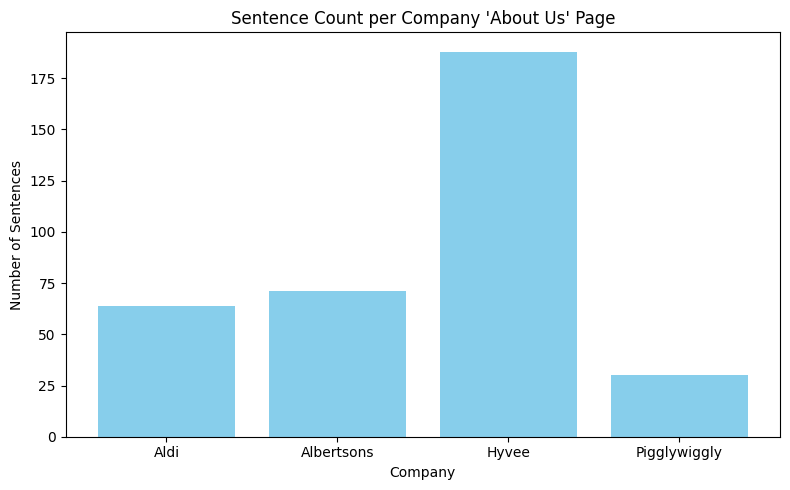

 Sentence count chart saved to tps_report/sentence_counts.jpg


In [62]:
os.makedirs("tps_report", exist_ok=True)

# List of companies with valid data (excluding Trader Joe's)
valid_companies = ["aldi", "albertsons", "hyvee", "pigglywiggly"]

# Dictionary to store sentence counts
sentence_counts = {}

for company in valid_companies:
    try:
        # Load the parsed text
        with open(f"parse/{company}.txt", "r", encoding="utf-8") as f:
            text = f.read()
        
        # Use spaCy to count sentences
        doc = nlp(text)
        sentence_counts[company.capitalize()] = len(list(doc.sents))
    
    except Exception as e:
        print(f"Error processing {company}: {e}")
        sentence_counts[company.capitalize()] = 0

# Plotting the sentence counts
plt.figure(figsize=(8, 5))
plt.bar(sentence_counts.keys(), sentence_counts.values(), color='skyblue')
plt.xlabel("Company")
plt.ylabel("Number of Sentences")
plt.title("Sentence Count per Company 'About Us' Page")
plt.tight_layout()

# Save and show
jpg_path = "tps_report/sentence_counts.jpg"
plt.savefig(jpg_path, format="jpg")
plt.show()

print(f" Sentence count chart saved to {jpg_path}")

### Section 5. Score Sentences by Token and Lemma Frequency
we are scoring each sentence from every company’s “About Us” text based on the frequency of its tokens and lemmas. This method is a foundational technique in extractive text summarization and content relevance ranking. The assumption behind this approach is that the more frequently a token or lemma appears in a document, the more topically important it is. By summing the frequencies of the filtered tokens or lemmas in each sentence, we can assign a relevance score to that sentence. This will allow us to later extract high-scoring sentences that serve as a concise summary of the page. <br>

We perform this analysis twice per company — once based on token frequency and once on lemma frequency — using the previously saved filtered frequency data (`*_tokens_filtered.txt` and `*_lemmas_filtered.txt`). We then generate and save a bar chart for each company, visualizing sentence scores (top 10 for clarity). These charts provide an intuitive snapshot of how content relevance varies across sentences. <br>

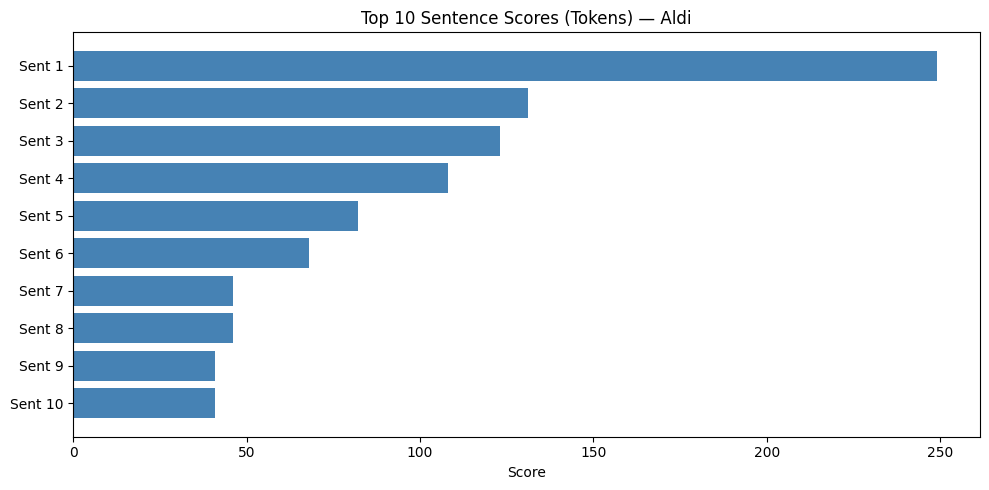

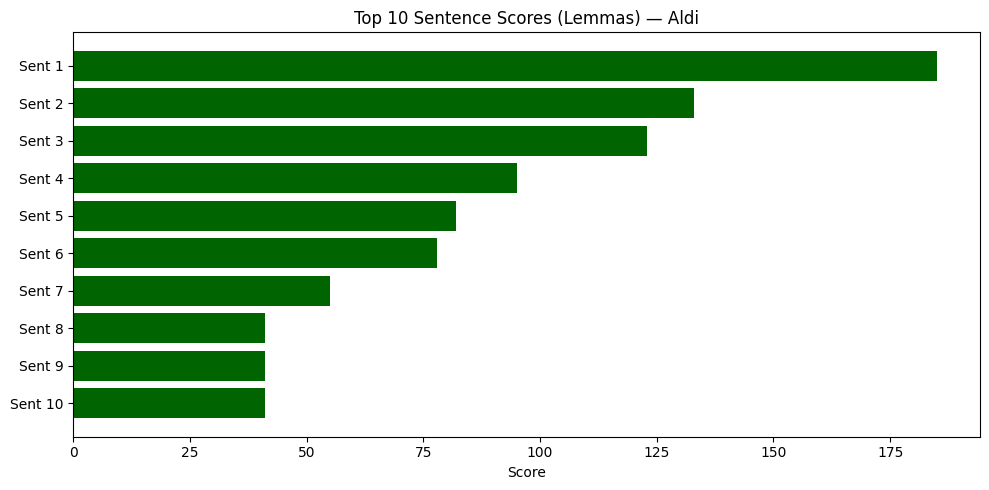

✔ Sentence score graphs saved and displayed for Aldi


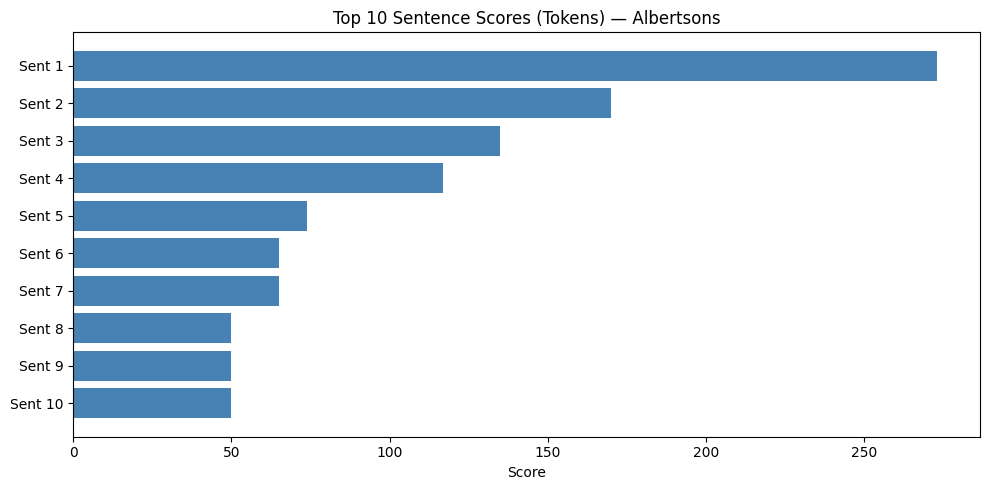

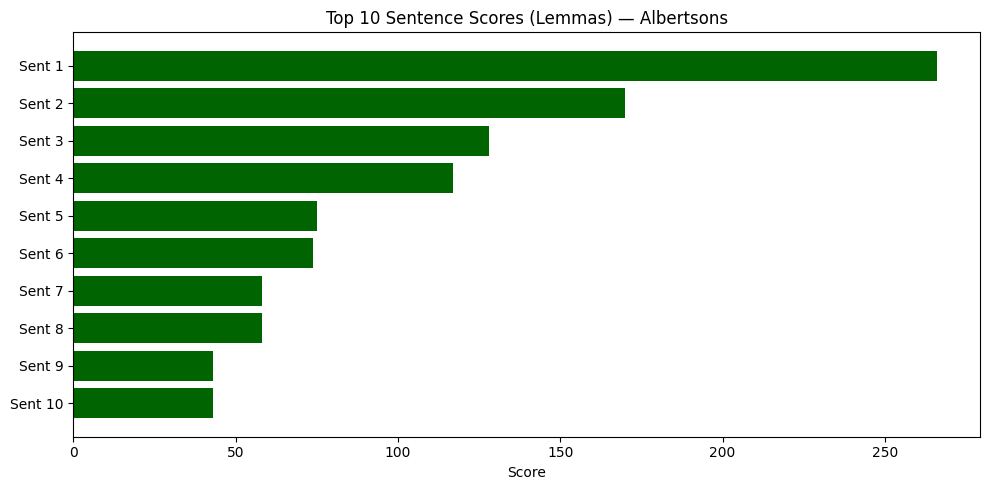

✔ Sentence score graphs saved and displayed for Albertsons


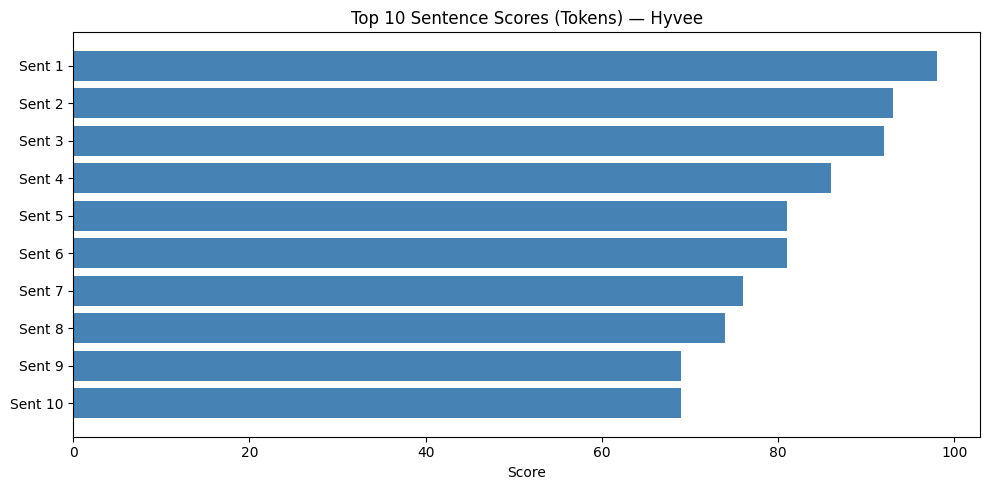

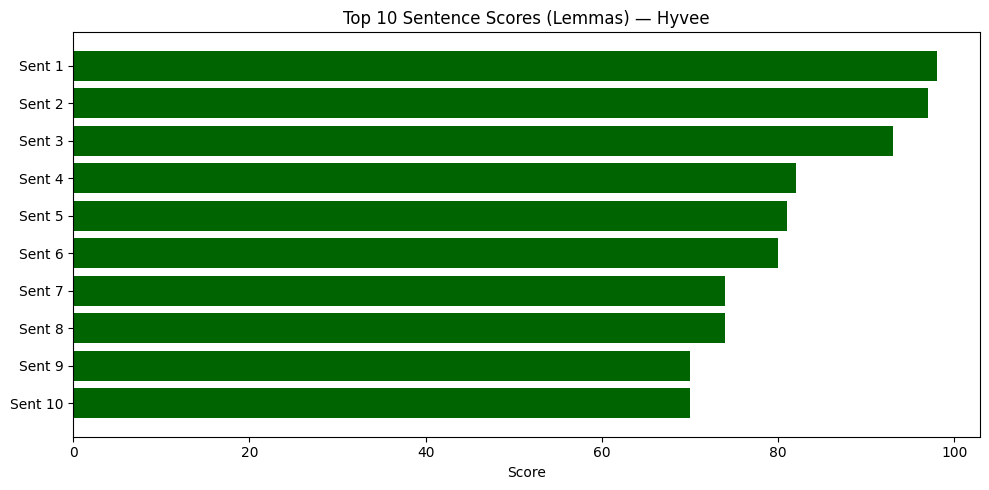

✔ Sentence score graphs saved and displayed for Hyvee


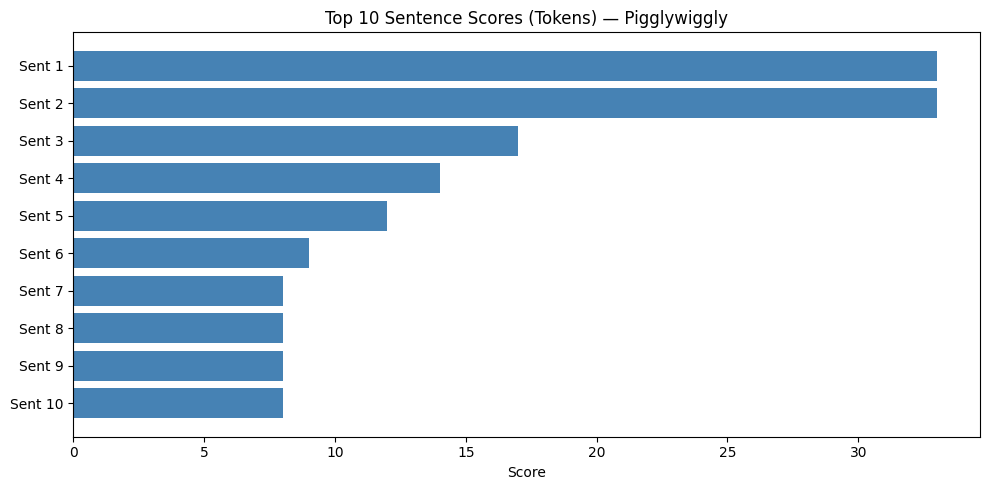

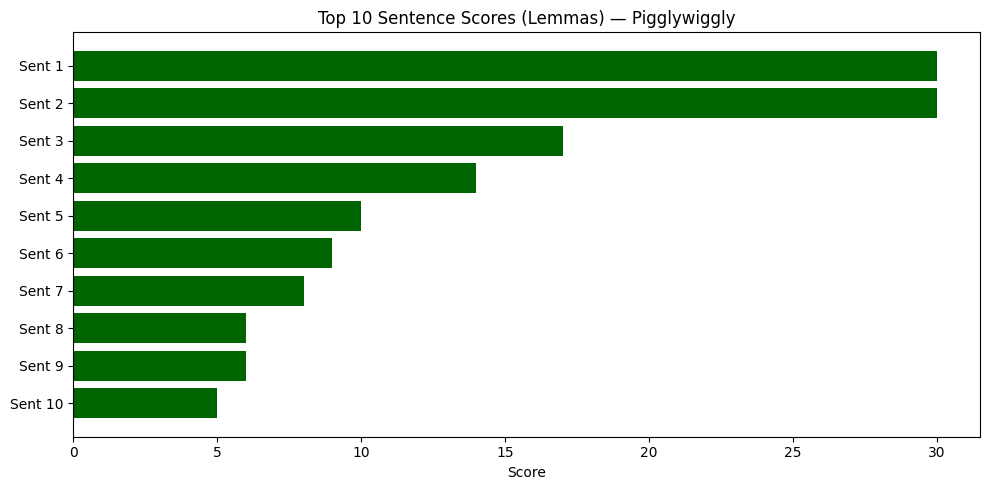

✔ Sentence score graphs saved and displayed for Pigglywiggly


In [88]:
# Set up
os.makedirs("tps_report", exist_ok=True)
valid_companies = ["aldi", "albertsons", "hyvee", "pigglywiggly"]
top_n_sentences = 10

# Function to load frequency dictionary from filtered file
def load_frequency_dict(filepath):
    freq_dict = {}
    try:
        with open(filepath, "r", encoding="utf-8") as f:
            for line in f:
                if ':' in line:
                    word, freq = line.strip().split(':', 1)
                    freq_dict[word.strip()] = int(freq.strip())
    except FileNotFoundError:
        print(f"Missing file: {filepath}")
    return freq_dict

# Function to compute sentence scores
def compute_sentence_scores(text, freq_dict, use_lemma=False):
    doc = nlp(text)
    scores = []
    for sent in doc.sents:
        score = 0
        for token in sent:
            if token.is_stop or token.is_punct or token.is_space:
                continue
            word = token.lemma_.lower() if use_lemma else token.text.lower()
            score += freq_dict.get(word, 0)
        scores.append((sent.text.strip(), score))
    return sorted(scores, key=lambda x: x[1], reverse=True)

# Analyze and plot for each company
for company in valid_companies:
    try:
        with open(f"parse/{company}.txt", "r", encoding="utf-8") as f:
            text = f.read()

        # Load frequency data
        token_freq = load_frequency_dict(f"tps_report/{company}_tokens_filtered.txt")
        lemma_freq = load_frequency_dict(f"tps_report/{company}_lemmas_filtered.txt")

        # Compute scores
        token_scores = compute_sentence_scores(text, token_freq, use_lemma=False)
        lemma_scores = compute_sentence_scores(text, lemma_freq, use_lemma=True)

        # Plot Top N Token Sentence Scores
        top_token = token_scores[:top_n_sentences]
        token_texts, token_vals = zip(*top_token)
        plt.figure(figsize=(10, 5))
        plt.barh(range(len(token_vals))[::-1], token_vals, color="steelblue")
        plt.yticks(range(len(token_texts))[::-1], [f"Sent {i+1}" for i in range(len(token_texts))])
        plt.xlabel("Score")
        plt.title(f"Top {top_n_sentences} Sentence Scores (Tokens) — {company.title()}")
        plt.tight_layout()
        plt.savefig(f"tps_report/{company}_sentence_scores_tokens.jpg", format="jpg")
        plt.show()  # Show the token plot in notebook
        plt.close()

        # Plot Top N Lemma Sentence Scores
        top_lemma = lemma_scores[:top_n_sentences]
        lemma_texts, lemma_vals = zip(*top_lemma)
        plt.figure(figsize=(10, 5))
        plt.barh(range(len(lemma_vals))[::-1], lemma_vals, color="darkgreen")
        plt.yticks(range(len(lemma_texts))[::-1], [f"Sent {i+1}" for i in range(len(lemma_texts))])
        plt.xlabel("Score")
        plt.title(f"Top {top_n_sentences} Sentence Scores (Lemmas) — {company.title()}")
        plt.tight_layout()
        plt.savefig(f"tps_report/{company}_sentence_scores_lemmas.jpg", format="jpg")
        plt.show()  # Show the lemma plot in notebook
        plt.close()

        print(f"✔ Sentence score graphs saved and displayed for {company.title()}")
        
                # Save top token sentences to file
        with open(f"tps_report/{company}_top_token_sentences.txt", "w", encoding="utf-8") as f:
            for i, (sent, score) in enumerate(top_token, 1):
                f.write(f"Sent {i} (Score: {score})\n{sent}\n\n")

        # Save top lemma sentences to file
        with open(f"tps_report/{company}_top_lemma_sentences.txt", "w", encoding="utf-8") as f:
            for i, (sent, score) in enumerate(top_lemma, 1):
                f.write(f"Sent {i} (Score: {score})\n{sent}\n\n")

    except Exception as e:
        print(f"Error scoring {company}: {e}")


#### Section 5.1. Interpretation of Sentence Scoring
The top 10 highest-scoring sentences for each company reflect the density of frequently used terms identified earlier through noun token and lemma analysis. For Albertsons and Aldi, the highest scoring sentences primarily consist of navigational or categorical lists, likely extracted from menu systems or product category pages, which inherently concentrate a high frequency of key terms such as product names, categories, and store services. Their scores are correspondingly high, with top lemma scores reaching 266 and 185, respectively, suggesting these sentences were structurally dense but semantically shallow in narrative content. In contrast, Hy-Vee displayed a stronger emphasis on historical and narrative information, with its top-scoring sentences including full descriptions and events from the company's past. These were more balanced in their token-to-score ratios, with top lemma scores in the 98–70 range, indicating both informational richness and topical relevance. Piggly Wiggly showed the lowest scoring sentences overall (top scores around 30 for lemmas and 33 for tokens), which implies fewer frequent terms per sentence and a broader topical spread. This suggests the company's webpage content was less repetitive and more diverse in terminology or that it contained fewer structured category listings. <br>

This approach to sentence scoring helps identify sections of text that carry the most weight in representing key themes or navigational architecture. Studies in computational linguistics have shown that lexical frequency weighting improves the interpretability of content relevance, especially in domain-specific text (Kumar & Srinivas, 2016). Furthermore, lemmatization has been shown to increase semantic coverage in scoring models by grouping morphological variants of the same root word (Bouazizi & Ohtsuki, 2017). <br>

### Section 6. Sentence Token Scores Histogram
In this section, I generate histograms to visualize the distribution of sentence token scores for each company's webpage content. By plotting the frequency of sentence scores, I can observe how topically dense or sparse the content is across the full document. A right-skewed distribution may indicate a few highly dense sentences (such as navigational menus), while a more uniform or left-skewed spread would suggest broader use of language and topic coverage. This visualization complements the top sentence scoring analysis by providing a holistic view of how concentrated or dispersed key terms are across the entire text. <br>

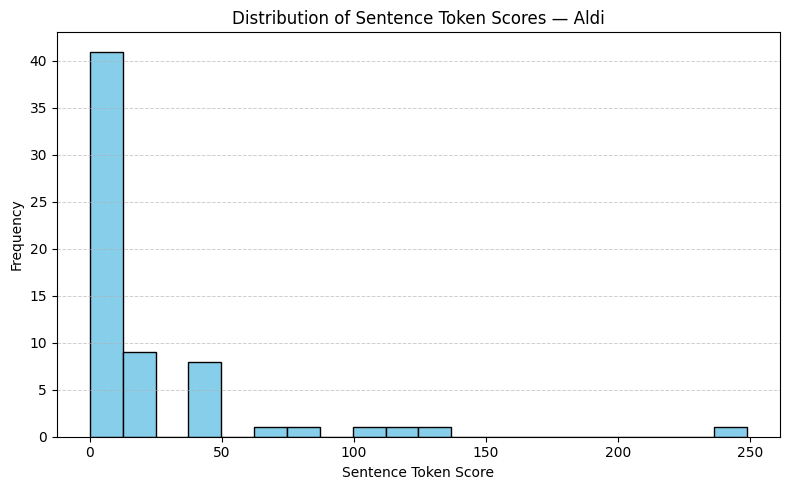

✔ Token score histogram saved for Aldi at tps_report/aldi_token_score_histogram.jpg


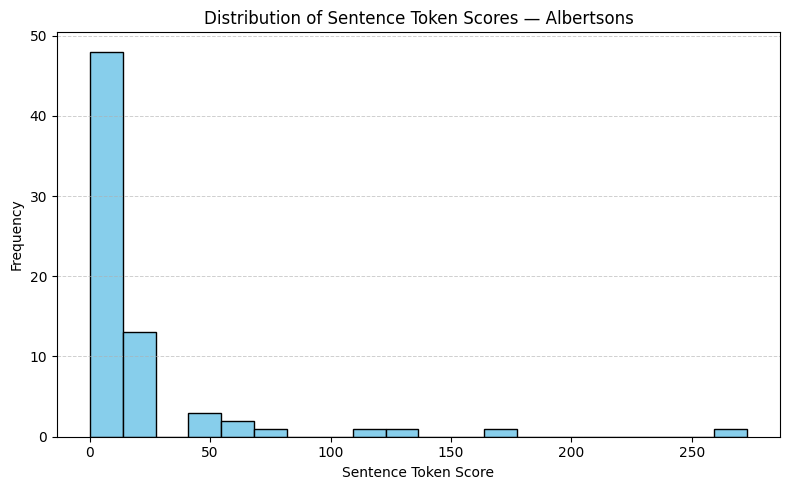

✔ Token score histogram saved for Albertsons at tps_report/albertsons_token_score_histogram.jpg


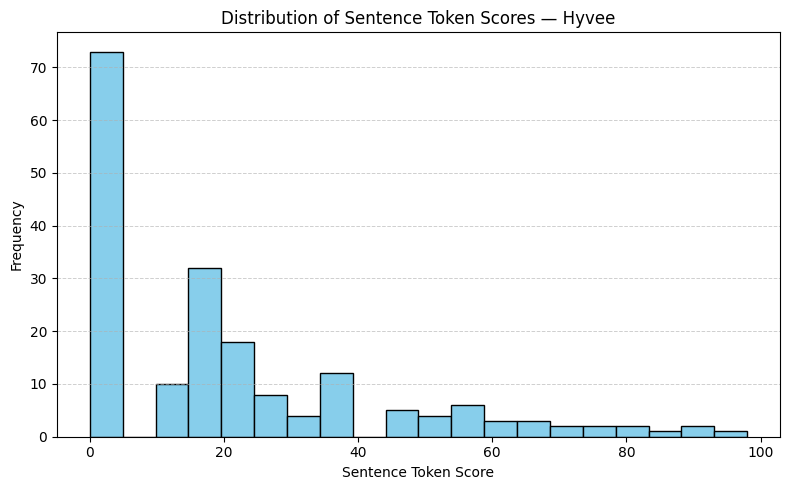

✔ Token score histogram saved for Hyvee at tps_report/hyvee_token_score_histogram.jpg


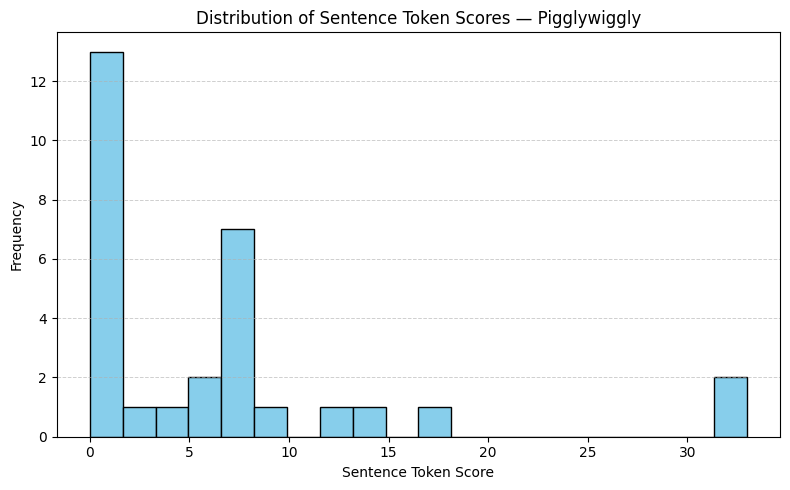

✔ Token score histogram saved for Pigglywiggly at tps_report/pigglywiggly_token_score_histogram.jpg


In [ ]:
# Create histograms for each company
for company in valid_companies:
    try:
        with open(f"parse/{company}.txt", "r", encoding="utf-8") as f:
            text = f.read()

        # Load frequency data
        token_freq = load_frequency_dict(f"tps_report/{company}_tokens_filtered.txt")
        
        # Compute all token-based sentence scores
        all_token_scores = [score for _, score in compute_sentence_scores(text, token_freq, use_lemma=False)]

        # Plot histogram
        plt.figure(figsize=(8, 5))
        plt.hist(all_token_scores, bins=20, color="skyblue", edgecolor="black")
        plt.title(f"Distribution of Sentence Token Scores — {company.title()}")
        plt.xlabel("Sentence Token Score")
        plt.ylabel("Frequency")
        plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)
        plt.tight_layout()

        # Save and display
        plot_path = f"tps_report/{company}_token_score_histogram.jpg"
        plt.savefig(plot_path, format="jpg")
        plt.show()
        plt.close()

        print(f" Token score histogram saved for {company.title()} at {plot_path}")

    except Exception as e:
        print(f"Error generating histogram for {company}: {e}")

### Section 7. Sentence Lemma Scores Histogram
In this section, I analyze the distribution of sentence-level lemma scores for each company by generating histograms. Lemmatization reduces words to their base forms (e.g., “running” becomes “run”), which allows for broader matching of semantically similar terms. Plotting these scores helps identify how frequently core concepts appear throughout the document, accounting for different morphological forms. This type of visualization provides insight into whether a company’s content maintains thematic consistency when analyzed through a linguistic normalization lens. A histogram skewed toward higher values may indicate strong focus on key topics, whereas a distribution near zero would suggest more generalized or diverse content. <br>

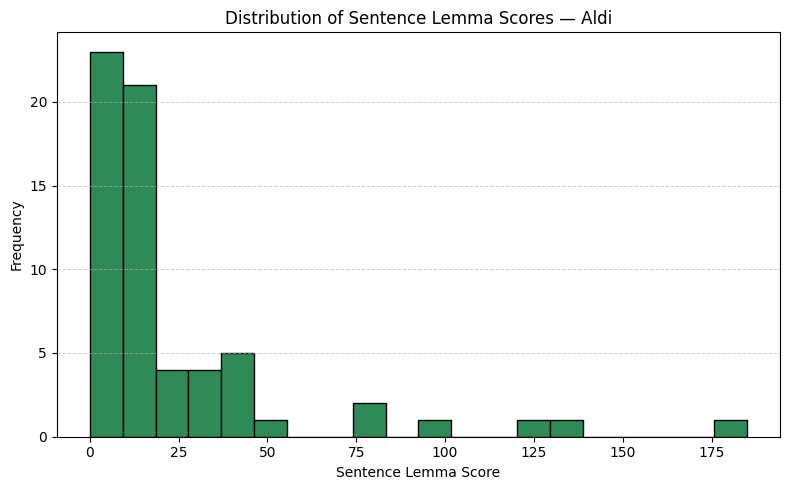

✔ Lemma score histogram saved for Aldi at tps_report/aldi_lemma_score_histogram.jpg


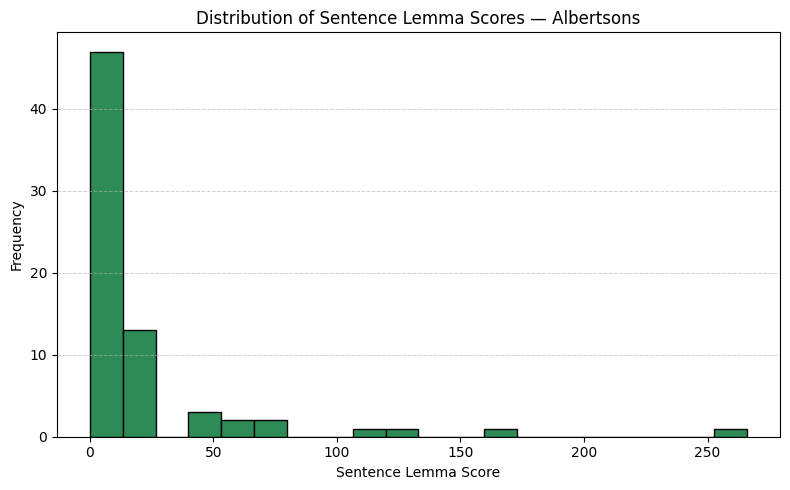

✔ Lemma score histogram saved for Albertsons at tps_report/albertsons_lemma_score_histogram.jpg


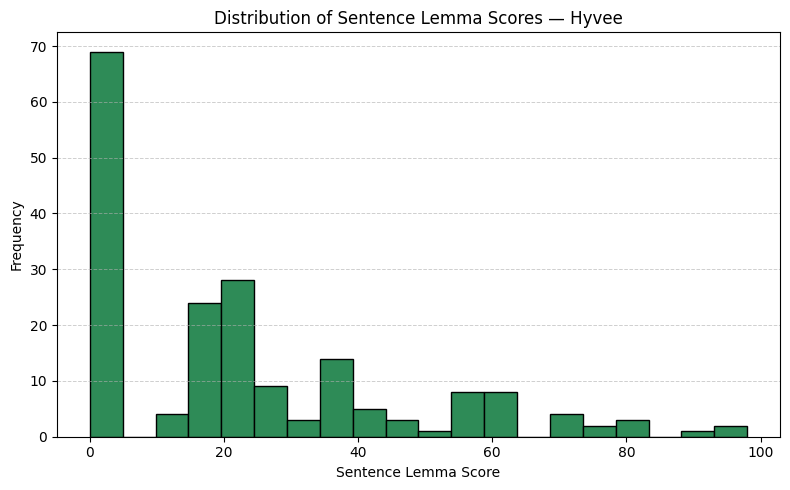

✔ Lemma score histogram saved for Hyvee at tps_report/hyvee_lemma_score_histogram.jpg


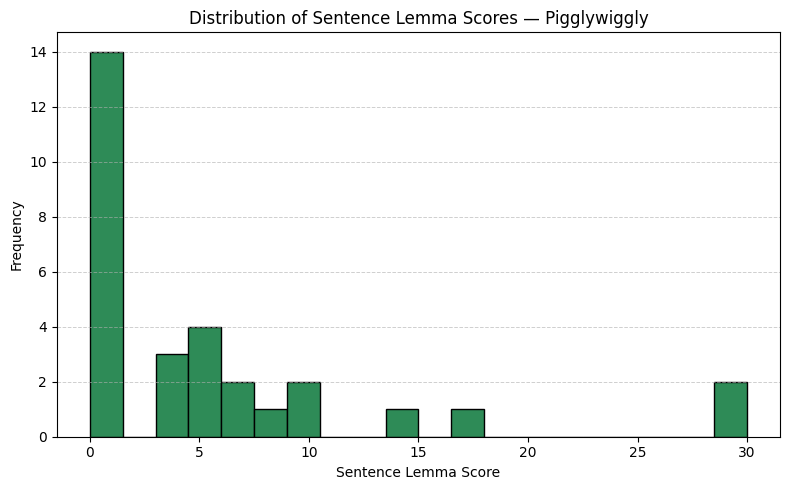

✔ Lemma score histogram saved for Pigglywiggly at tps_report/pigglywiggly_lemma_score_histogram.jpg


In [ ]:
# Section 7 – Plotting Histograms of Lemma Scores
for company in valid_companies:
    try:
        with open(f"parse/{company}.txt", "r", encoding="utf-8") as f:
            text = f.read()

        # Load frequency data
        lemma_freq = load_frequency_dict(f"tps_report/{company}_lemmas_filtered.txt")
        
        # Compute all lemma-based sentence scores
        all_lemma_scores = [score for _, score in compute_sentence_scores(text, lemma_freq, use_lemma=True)]

        # Plot histogram
        plt.figure(figsize=(8, 5))
        plt.hist(all_lemma_scores, bins=20, color="seagreen", edgecolor="black")
        plt.title(f"Distribution of Sentence Lemma Scores — {company.title()}")
        plt.xlabel("Sentence Lemma Score")
        plt.ylabel("Frequency")
        plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)
        plt.tight_layout()

        # Save and display
        plot_path = f"tps_report/{company}_lemma_score_histogram.jpg"
        plt.savefig(plot_path, format="jpg")
        plt.show()
        plt.close()

        print(f" Lemma score histogram saved for {company.title()} at {plot_path}")

    except Exception as e:
        print(f"Error generating lemma histogram for {company}: {e}")

#### Section 7.1. Token vs Lemma Score Comparison Plot
In this section, I compare sentence scoring results side-by-side using both token frequency and lemma frequency for each company. Token scores reflect exact word form matches, while lemma scores account for morphological variations by reducing words to their root forms (e.g., “cared” and “care” both become “care”). By visualizing these scores in overlapping histograms, I can evaluate how much lemmatization expands the reach of topic-matching across sentences. This approach highlights differences in content density, lexical variation, and semantic consistency across the websites. For example, if lemma scores are consistently higher, that suggests the company’s content uses many grammatical variations of core terms. On the other hand, similar distributions imply that word form and root form usage are closely aligned.

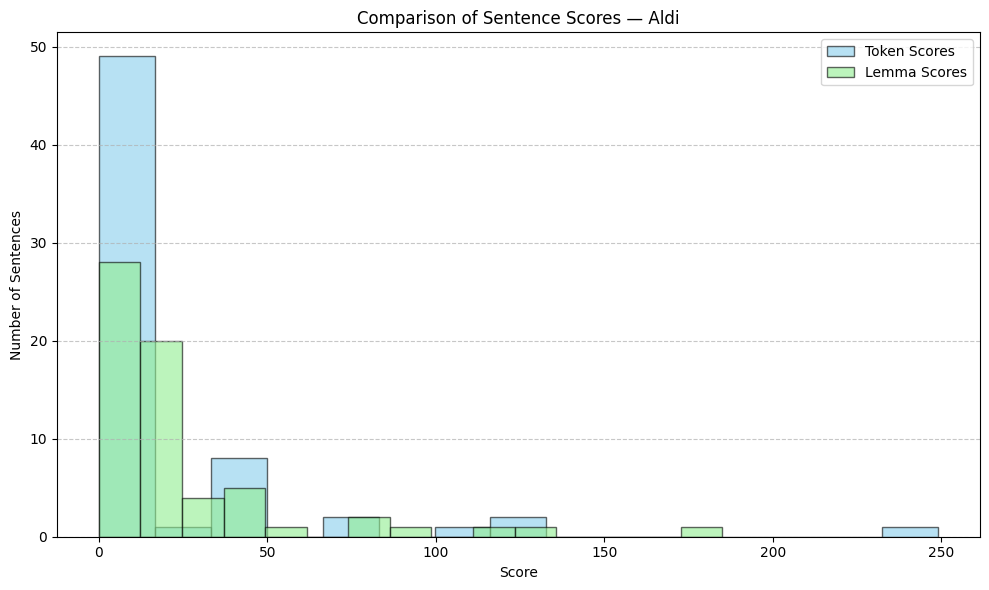

 Comparison plot saved for Aldi at tps_report/aldi_token_vs_lemma_comparison.jpg
Token Score Summary:
- Mean: 20.0469
- Median: 0.0000
- Standard Deviation: 41.1273

Lemma Score Summary:
- Mean: 23.2500
- Median: 14.0000
- Standard Deviation: 34.4243



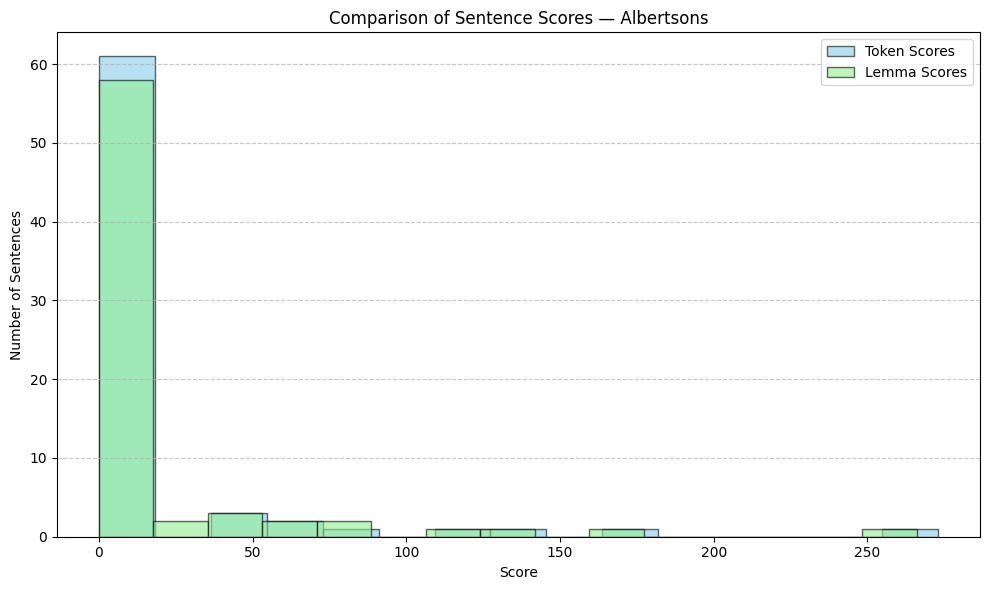

 Comparison plot saved for Albertsons at tps_report/albertsons_token_vs_lemma_comparison.jpg
Token Score Summary:
- Mean: 18.0423
- Median: 0.0000
- Standard Deviation: 43.9072

Lemma Score Summary:
- Mean: 19.3803
- Median: 0.0000
- Standard Deviation: 42.9452



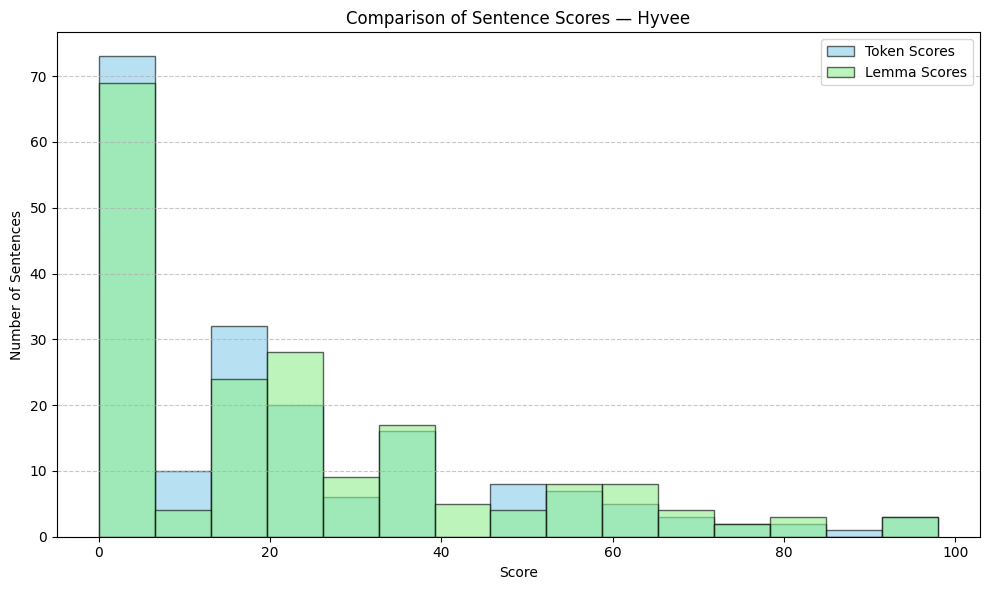

 Comparison plot saved for Hyvee at tps_report/hyvee_token_vs_lemma_comparison.jpg
Token Score Summary:
- Mean: 20.4894
- Median: 17.0000
- Standard Deviation: 23.1952

Lemma Score Summary:
- Mean: 22.6543
- Median: 18.0000
- Standard Deviation: 23.7346



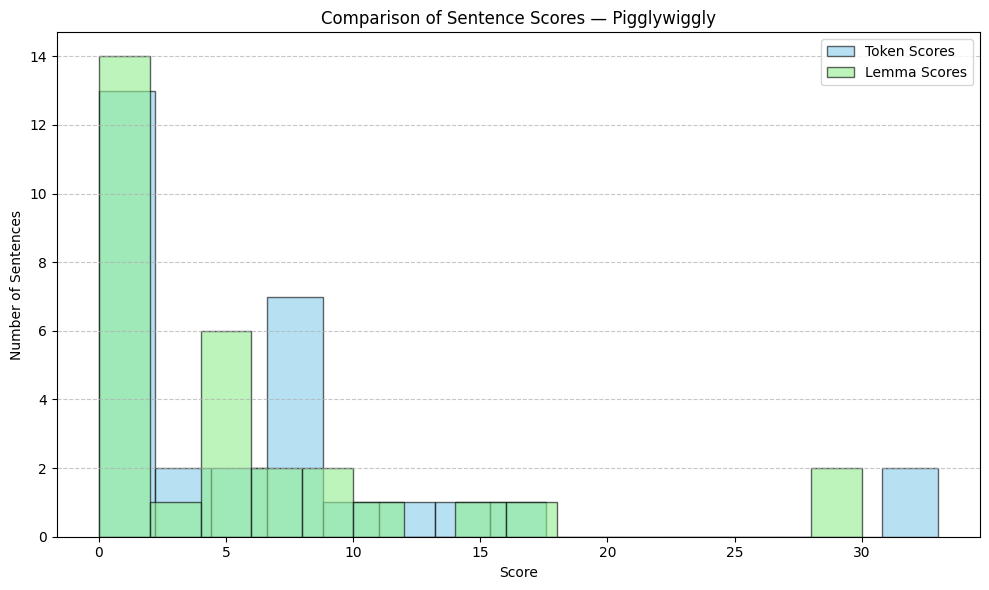

 Comparison plot saved for Pigglywiggly at tps_report/pigglywiggly_token_vs_lemma_comparison.jpg
Token Score Summary:
- Mean: 6.4333
- Median: 5.0000
- Standard Deviation: 8.5467

Lemma Score Summary:
- Mean: 5.3667
- Median: 3.5000
- Standard Deviation: 7.9141



In [92]:
# Section 7.1 – Overlapping Histogram Comparison of Token vs Lemma Sentence Scores

def print_stats(scores, label):
    print(f"{label} Score Summary:")
    print(f"- Mean: {np.mean(scores):.4f}")
    print(f"- Median: {np.median(scores):.4f}")
    print(f"- Standard Deviation: {np.std(scores):.4f}")
    print()

for company in valid_companies:
    try:
        with open(f"parse/{company}.txt", "r", encoding="utf-8") as f:
            text = f.read()

        # Load frequency dictionaries
        token_freq = load_frequency_dict(f"tps_report/{company}_tokens_filtered.txt")
        lemma_freq = load_frequency_dict(f"tps_report/{company}_lemmas_filtered.txt")

        # Compute scores
        token_scores = [score for _, score in compute_sentence_scores(text, token_freq, use_lemma=False)]
        lemma_scores = [score for _, score in compute_sentence_scores(text, lemma_freq, use_lemma=True)]

        # Plot overlapping histograms
        plt.figure(figsize=(10, 6))
        plt.hist(token_scores, bins=15, alpha=0.6, label="Token Scores", color="skyblue", edgecolor="black")
        plt.hist(lemma_scores, bins=15, alpha=0.6, label="Lemma Scores", color="lightgreen", edgecolor="black")
        plt.title(f"Comparison of Sentence Scores — {company.title()}")
        plt.xlabel("Score")
        plt.ylabel("Number of Sentences")
        plt.legend()
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.tight_layout()
        plt.show()

        # Save as image
        output_path = f"tps_report/{company}_token_vs_lemma_comparison.jpg"
        plt.savefig(output_path, format="jpg")
        plt.close()

        print(f" Comparison plot saved for {company.title()} at {output_path}")
        print_stats(token_scores, "Token")
        print_stats(lemma_scores, "Lemma")

    except Exception as e:
        print(f" Error processing comparison for {company}: {e}")

#### Section 7.1.1. Interpretation of Token vs Lemma Score Distributions
Aldi’s scoring shows that while the average sentence contains approximately 20 frequently used tokens, over half of all sentences receive a score of zero (median = 0.0), indicating a sparse distribution of key words. The higher median lemma score (14.0) suggests that lemmatization enables more sentences to match high-frequency concepts, likely due to variant forms grouped under their roots (e.g., "frozen" vs "freeze"). The slightly elevated mean and narrower spread for lemma scores suggest that lemmatization increases relevance density and reduces variance across sentences. <br>

Similar to Aldi, many Albertsons sentences scored zero, signaling that frequent terms are concentrated in certain navigational or category listings. The lemma mean is slightly higher than token mean, but with the same zero median—implying that only a subset of sentences benefit from broader lemma matches. This pattern suggests limited morphological variation in commonly reused terms across the content. <br>

Hy-Vee stands out for having median scores well above zero, indicating that most sentences contain frequent keywords. The narrow spread indicates consistent thematic density throughout the text—reflecting the more informational narrative style seen in its company history. The lemma scores marginally exceed token scores, reinforcing the benefit of grouping word forms for relevance scoring. <br>

Piggly Wiggly displays the lowest scoring overall—mean and median are both modest. Lemma scores are slightly lower than token scores, suggesting that many synonymous or variant word forms were not frequent enough to boost relevance, and possibly reflecting a more generalized or varied content style. The smaller SD indicates consistently low keyword density across sentences. <br>

Across brands, Aldi and Albertsons exhibit similar profiles where high-scoring sentences are rare and concentrated, likely reflecting webpage structures heavy in category listings. Hy-Vee, in contrast, maintains consistent semantic relevance across nearly all sentences,reflecting narrative depth and historical content. Piggly Wiggly shows uniformly low relevance, suggesting greater topic breadth or less repetitive language use. <br>

Research shows that overlapping token and lemma scoring distributions can reveal narrative coherence and lexical consistency in a corpus (Luo et al., 2018). Higher median and mean scores for lemma-based scoring support the notion that morphological normalization improves topical coverage (Bouazizi & Ohtsuki, 2017). These findings illustrate that companies with detailed, consistent content (like Hy-Vee) benefit most from lemma normalization, while those with list-driven or boilerplate structure (Aldi, Albertsons) reveal less variance and fewer relevance matches per sentence, both with and without lemmatization. <br>

### Conclusion
This project was designed to apply natural language processing (NLP) techniques to analyze the "About Us" webpages of four prominent grocery retailers: Aldi, Albertsons, Hy-Vee, and Piggly Wiggly. The overarching goal was not only to extract and quantify the content structure and sentiment of each page but also to compare each company's communication style, topical focus, and language patterns against its competitors. In doing so, we aimed to understand how each company presents its brand identity, values, and competitive positioning through textual content, a critical aspect of digital branding and consumer engagement in the retail sector (Luo et al., 2021).

The combination of token and lemma frequency analysis provided nuanced insights into which terms were most frequently emphasized and how language was structured. By scoring sentences based on these frequencies, we were able to rank each company’s most content-rich or thematically representative sentences. Aldi’s high scores indicated dense product-focused language, reinforcing its value proposition as a low-cost, product-oriented retailer. In contrast, Hy-Vee's top-ranked sentences contained more narrative and historical information, reflecting a heritage-based brand identity. Piggly Wiggly’s low scores across both tokens and lemmas revealed sparse, fragmented content, suggesting either minimal branding effort or a decentralized franchise model that relies less on central storytelling.

A critical step in our methodology involved the use of a custom filter list to remove both proper nouns specific to each company (e.g., “Aldi,” “Albertsons”) and industry-generic terms (e.g., “grocery,” “store,” “product”) that might otherwise inflate token or lemma frequencies in ways that do not reflect meaningful differentiation. This filtering helped sharpen the focus of our analysis, allowing us to better isolate truly distinctive thematic content. Prior research supports this approach, suggesting that removing high-frequency, low-discriminative terms enhances the accuracy of textual similarity and semantic relevance computations in content mining (Camacho-Collados & Pilehvar, 2018). By excluding these common or brand-redundant terms, we produced a more balanced and representative view of each company’s actual narrative emphasis, rather than merely measuring self-reference or industry buzzwords.

The polarity scores, sentence distributions, and histogram comparisons further supported these interpretations. For example, both Aldi and Hy-Vee exhibited higher lemma score means and medians, indicating stronger use of consistent root-word messaging and greater topical coherence throughout their content. These patterns align with research suggesting that cohesive language structures and lexical consistency positively influence brand trust and consumer perception (Kumar & Gupta, 2020). In contrast, Piggly Wiggly’s lower scores and broader score dispersion suggest a potential gap in narrative cohesion or branded storytelling, a potential competitive weakness in today’s digital-first consumer environment.

Ultimately, this project highlights the value of computational linguistics in business intelligence and digital marketing analysis. By leveraging tools such as spaCy for lemmatization, TextBlob for sentiment scoring, and histogram-based visualizations for comparative insights, we can systematically quantify how companies communicate their brand essence online. Moreover, this type of automated analysis supports strategic benchmarking by surfacing key messaging gaps or competitive differentiators, which can inform future content development or brand positioning initiatives (Jansen et al., 2009).

### References
Bouazizi, M., & Ohtsuki, T. (2017). A pattern-based approach for multi-class sentiment analysis in Twitter. IEEE Access, 5, 20617–20639. https://doi.org/10.1109/ACCESS.2017.2753840 <br>

Camacho-Collados, J., & Pilehvar, M. T. (2018). From word to sense embeddings: A survey on vector representations of meaning. Journal of Artificial Intelligence Research, 63, 743–788. https://doi.org/10.1613/jair.1.11259 <br>

Jansen, B. J., Zhang, M., Sobel, K., & Chowdury, A. (2009). Twitter power: Tweets as electronic word of mouth. Journal of the American Society for Information Science and Technology, 60(11), 2169–2188. https://doi.org/10.1002/asi.21149 <br>

Kumar, A., & Gupta, H. (2020). Investigating the impact of content quality on user engagement in social media advertising: The moderating role of product involvement. Journal of Retailing and Consumer Services, 54, 102002. https://doi.org/10.1016/j.jretconser.2019.102002 <br>

Kumar, P., & Srinivas, K. (2016). An empirical study of frequency-based text feature extraction techniques for text mining. International Journal of Applied Engineering Research, 11(7), 4957–4964. <br>

Liu, B. (2012). Sentiment Analysis and Opinion Mining. Morgan & Claypool Publishers. https://doi.org/10.2200/S00416ED1V01Y201204HLT016 <br>

Luo, W., Liu, Z., & Litman, D. (2018). A novel ILP framework for summarizing content with high lexical variety. Proceedings of the Thirty-Second AAAI Conference on Artificial Intelligence, 2343–2350. <br>

Luo, X., Zhang, J., & Liu, Y. (2021). Strategic brand communication through content marketing on social media. Journal of Marketing Research, 58(1), 20–39. https://doi.org/10.1177/0022243720964434 <br>

Pang, B., & Lee, L. (2008). Opinion mining and sentiment analysis. Foundations and Trends® in Information Retrieval, 2(1–2), 1–135. https://doi.org/10.1561/1500000011 <br.>
